# Installs:

In [ ]:
!pip install ucimlrepo

# Imports:

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from random import sample
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)

# variable information
print(adult.variables)


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

# Read up on what the data means + Decisions

Each column meaning:

- age: A person's (datapoint's) age. This column is represented in integers.
- workclass: This column has missing data, is categorical, and represents the type of employment. Options include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: This column represents how many people the census believes this data point represents. It is not categorical, but represented in integers.
- education: Level of education for the data point. This column is categorical, and options include preschool, 1st-4th, amount of middle school grades completed, amount of high school grades completed, and amount of college completed (up to bachelors).
- education-num: The same thing as education, but encoded to values 1-16.
- marital-status: This column is for marriage status and is categorical. A person can be married, divorced, never married, seperated, married to a spouse in the Armed Forces, Widowed, or married to a spouse who is "absent," meaning they live apart.
- occupation: The type of occupation the person has. This column does have missing data and is categorical. Options include: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: This column is categorical, and determines a person's status in their relationship (marriage taking precedence over family). Options include: Wife, Own-child (meaning the person is a child), Husband, Not-in-family (the person does not have a family), Other-relative (the person is an aunt/uncle/etc), Unmarried.
- race: This column is categorical and determines a person's race or if they are "other." Options include: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: A binary column; male or female.
- capital-gain: The amount of money made in a year by selling property. If this is greater than 0, capital-loss is equal to 0 (proof in a code block below)
- capital-loss: The amount of money lost in a year by selling property. If this is greater than 0, capital-gain is equal to 0 (proof in a code block below)
- hours-per-week: the number of hours worked per week. Takes a value between 1 a nd 99, inclusive
- native-country: Country of origin. One of 40 countries, as well as outlying US  territories.
- Income: two possible values. Either an income of more than 50k a year, or less than/exactly 50k a year.


From this information, we decided to make these changes / drops to columns in preprocessing:
- We're going to drop education, since we have the same thing as a number, education-num (so it is already encoded).

- We're going to turn capital-gain (how much a person profits (NOT REVENUE) from selling property) and capital-loss (negative profit from selling property) into one category: net-capital-gain.

- In relationship, we're going to remove "Other relative" since we do not know to whom this relationship pertains do, and cannot make an interesting prediction or classification based on it.

- We're going to remove null values since they only comprise a small percentage of our data.

- We're going to categorize non-integer values such as marital status in order to visualize our data.

In [ ]:
# Proof that capital gain and capital loss are mutually exclusive
# (read: if one of the values are not zero, the other one must be zero)
# Proof by contradiction.
gain_and_loss = X[["capital-gain", "capital-loss"]]
g_0 = gain_and_loss.loc[(gain_and_loss['capital-gain'] > 0) & (gain_and_loss["capital-loss"] > 0)]
# If there was one value with both capital gain and capital loss greater than 0,
# There would be values in g_0. However you can see it's empty. Q.E.D.
g_0

,capital-gain,capital-loss


In [ ]:
# Read up on what the data means
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [ ]:
adult.variables;

# Initial Preprocessing:

## Imputation

In [ ]:
# Check for number of null values on each feature
X.isna().sum(axis='rows')

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

In [ ]:
X[X['workclass'].isna()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
32565,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
32567,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States
32574,58,NaN,299831,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,35,United-States
32583,72,NaN,132015,7th-8th,4,Divorced,NaN,Not-in-family,White,Female,0,0,6,United-States
32596,65,NaN,191846,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States


In [ ]:
X[X['occupation'].isna()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
32565,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
32567,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States
32574,58,NaN,299831,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,35,United-States
32583,72,NaN,132015,7th-8th,4,Divorced,NaN,Not-in-family,White,Female,0,0,6,United-States
32596,65,NaN,191846,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States


In [ ]:
X[X['native-country'].isna()]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
32580,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,NaN
32626,41,Private,109912,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,40,NaN
32644,44,Self-emp-inc,223881,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,99999,0,50,NaN
32749,34,State-gov,513100,Bachelors,13,Married-spouse-absent,Farming-fishing,Not-in-family,Black,Male,0,0,40,NaN
32814,42,Federal-gov,177937,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48245,46,Private,31411,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,NaN
48272,24,Private,127159,Some-college,10,Never-married,Other-service,Other-relative,White,Female,0,0,24,NaN
48604,24,State-gov,161783,Bachelors,13,Never-married,Transport-moving,Not-in-family,Black,Male,0,0,40,NaN
48651,34,Private,143776,Masters,14,Never-married,Prof-specialty,Not-in-family,Black,Male,0,0,45,NaN


In [ ]:
# Shallow copy of X
temp = X.copy()

# Store missing row numbers into array
missing_rows_indices = temp[(temp.isnull().any(axis=1)) | (temp['relationship'] == 'Other-relative')].index

# Drop all rows with missing data in features dataframe
X = X.dropna()
# Removing rows with "other-relative" since we can't make meaningful
# observations of it
X = X[X['relationship'] != 'Other-relative']

# Do the same with targets dataframe
y = y.drop(missing_rows_indices)

In [ ]:
missing_rows_indices

Int64Index([   74,   110,   144,   152,   159,   195,   198,   233,   317,
              335,
            ...
            48730, 48765, 48768, 48769, 48773, 48800, 48812, 48820, 48826,
            48838],
           dtype='int64', length=2662)

In [ ]:
X.shape

(46180, 14)

In [ ]:
y.shape

(46180, 1)

In [ ]:
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48836,<=50K.
48837,<=50K.
48839,<=50K.
48840,<=50K.


In [ ]:
# There are labels with a period at the end of '<=50K' or '>50K', remove them
y['income'] = y['income'].replace({'<=50K.': '<=50K'})
y['income'] = y['income'].replace({'>50K.': '>50K'})

In [ ]:
y

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48836,<=50K
48837,<=50K
48839,<=50K
48840,<=50K


## Normalize (or standardize)

In [ ]:
# Normalize (or standardize)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# We are normalizing the numerical columns
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

transformers = [
    ('MinMax', MinMaxScaler(), num_cols)
]

ct = ColumnTransformer(transformers, remainder='passthrough')
transformed = ct.fit_transform(X)

cols = num_cols + cat_cols

X_norm_df = pd.DataFrame(transformed, columns=cols)
X_norm_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0.30137,0.044131,0.8,0.02174,0.0,0.397959,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,0.452055,0.048052,0.8,0.0,0.0,0.122449,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,0.287671,0.137581,0.533333,0.0,0.0,0.397959,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,0.493151,0.150486,0.4,0.0,0.0,0.397959,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,0.150685,0.220635,0.8,0.0,0.0,0.397959,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [[ 3.0869964   0.86191597  4.67513593 19.3012846   2.85445409  3.80031797]]


<Axes: >

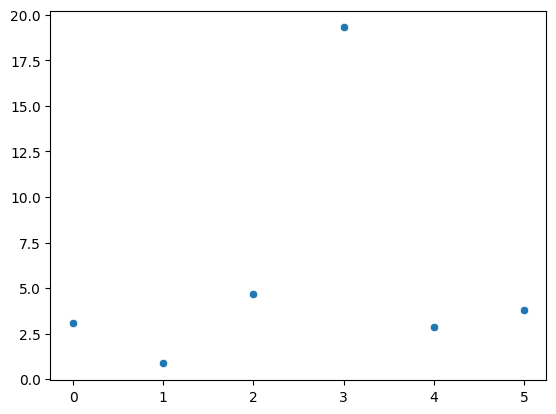

In [ ]:
# Here we partition our data for Training and Testing

from sklearn.linear_model import LogisticRegression

# We run a logistic regression model using only our numerical data
X_train, X_test, y_train, y_test = train_test_split(X_norm_df[num_cols],
                                                    y,
                                                    test_size=0.3,
                                                    random_state = 42)
logit_reg = LogisticRegression()
regmodel = logit_reg.fit(X_train, y_train)

print('Coefficients: \n', regmodel.coef_)
sns.scatterplot(x=list(range(0,len(regmodel.coef_[0]))),y=regmodel.coef_[0])

In [ ]:
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [ ]:
from sklearn.metrics import accuracy_score

yhat_train_predict = logit_reg.predict(X_train)
yhat_test_predict = logit_reg.predict(X_test)

print('\nTrain Accuracy Score (Normalization): %.8f' % accuracy_score(y_train, yhat_train_predict))
print('\nTest Accuracy Scorer (Normalization): %.8f' % accuracy_score(y_test, yhat_test_predict))


Train Accuracy Score (Normalization): 0.80582194

Test Accuracy Scorer (Normalization): 0.80525480


In [ ]:
# Here we standardize the numerical columns
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

transformers = [
    ('STD', StandardScaler(), num_cols)
]

ct = ColumnTransformer(transformers, remainder='passthrough')
transformed = ct.fit_transform(X)

cols = num_cols + cat_cols

X_std_df = pd.DataFrame(transformed, columns=cols)
X_std_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,0.014601,-1.059607,1.122624,0.139148,-0.21902,-0.057807,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,0.828962,-1.004673,1.122624,-0.147188,-0.21902,-2.256969,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,-0.059431,0.249804,-0.441839,-0.147188,-0.21902,-0.057807,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,1.05106,0.430626,-1.22407,-0.147188,-0.21902,-0.057807,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,-0.799759,1.413543,1.122624,-0.147188,-0.21902,-0.057807,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficients: 
 [[0.57287416 0.06713361 0.8123404  2.48019964 0.28600562 0.48561301]]


<Axes: >

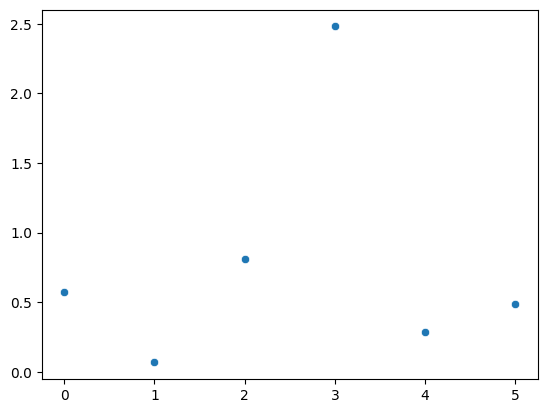

In [ ]:
# Here we partition our data for Training and Testing

from sklearn.linear_model import LogisticRegression

# We run a logistic regression model using only our numerical data
X_train, X_test, y_train, y_test = train_test_split(X_std_df[num_cols],
                                                    y,
                                                    test_size=0.3,
                                                    random_state = 42)
logit_reg = LogisticRegression()
regmodel = logit_reg.fit(X_train, y_train)

print('Coefficients: \n', regmodel.coef_)
sns.scatterplot(x=list(range(0,len(regmodel.coef_[0]))),y=regmodel.coef_[0])

In [ ]:
yhat_train_predict = logit_reg.predict(X_train)
yhat_test_predict = logit_reg.predict(X_test)

print('\nTrain Accuracy Score (Standardization): %.8f' % accuracy_score(y_train, yhat_train_predict))
print('\nTest Accuracy Score (Standardization): %.8f' % accuracy_score(y_test, yhat_test_predict))

# Note we are only using the numerical columns to predict which may explain why
# we have a low accuracy score


Train Accuracy Score (Standardization): 0.80851327

Test Accuracy Score (Standardization): 0.80835860


## Transformation

In [ ]:
# Run imputation and then transformation before data visualization so we don't
# map null values, we don't categorize null values, and don't
# map unnecessary columns

# Dropping the 'education' column, since we have education_num and don't need
# the extra column
X.drop('education', axis=1, inplace=True)

# Calculating 'net-capital-gain' and dropping 'capital-gain' and 'capital-loss'
X['net-capital-gain'] = X['capital-gain'] - X['capital-loss']
X.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)

## Encode (label vs one-hot)

In [ ]:
# Encode (label vs one-hot)
# Small note: make sure you run imputation before this function
# so that it doesn't categorize null values with a number

# label encoding
def enumerate_labels(dataset, string_labels):
  df = dataset.copy(deep=True)
  for label in string_labels:
    uniques = df[label].unique();
    conv_dict = {i:j for i,j in zip(uniques, range(1, len(uniques)+1))}
    df[label] = df[label].map(conv_dict)
  return df
X_label = enumerate_labels(X, ['workclass', 'race', 'native-country', 'occupation',
                         'relationship','marital-status', 'sex'])

# one-hot encoding
def encoding_pipeline(dataset, string_labels):
  df = dataset.copy(deep=True)
  encoder = OneHotEncoder(sparse_output=False)
  encoded_columns = encoder.fit_transform(df[string_labels])
  encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(string_labels))
  df = pd.concat([df, encoded_df], axis=1)
  df.drop(string_labels, axis=1, inplace=True)
  return df
X_encode = encoding_pipeline(X, ['workclass', 'race', 'native-country', 'occupation',
                         'relationship','marital-status', 'sex'])
print('Label rows and columns:')
print(X_label.shape)
print('Encoding rows and columns:')
print(X_encode.shape)
#for this dataset, it may be better to use label encoding as we have many ordinal categorical features.

Label rows and columns:
(46180, 12)
Encoding rows and columns:
(48549, 89)


# Data Exploration (subsample + visualizations):

## Look at subsample of observations

In [ ]:
# Look at subsample of observations
X.sample(n=50,random_state=99)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,net-capital-gain
16268,36,Self-emp-not-inc,408427,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,60,United-States,0
20063,22,Private,153516,13,Never-married,Prof-specialty,Not-in-family,White,Male,40,United-States,0
23951,29,Self-emp-not-inc,33798,9,Married-civ-spouse,Transport-moving,Husband,White,Male,45,United-States,0
32467,55,Private,199713,5,Married-civ-spouse,Craft-repair,Husband,White,Male,48,United-States,0
35025,39,Federal-gov,116369,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,48,United-States,0
40408,36,Private,131192,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,0
25567,25,Private,132683,9,Never-married,Priv-house-serv,Not-in-family,White,Female,50,United-States,0
13774,37,Private,295949,9,Never-married,Machine-op-inspct,Not-in-family,White,Male,40,United-States,0
35724,21,Private,145964,10,Married-civ-spouse,Craft-repair,Husband,White,Male,60,United-States,7298
39735,30,Private,213722,15,Never-married,Prof-specialty,Not-in-family,White,Male,50,United-States,0


##Visualize the data

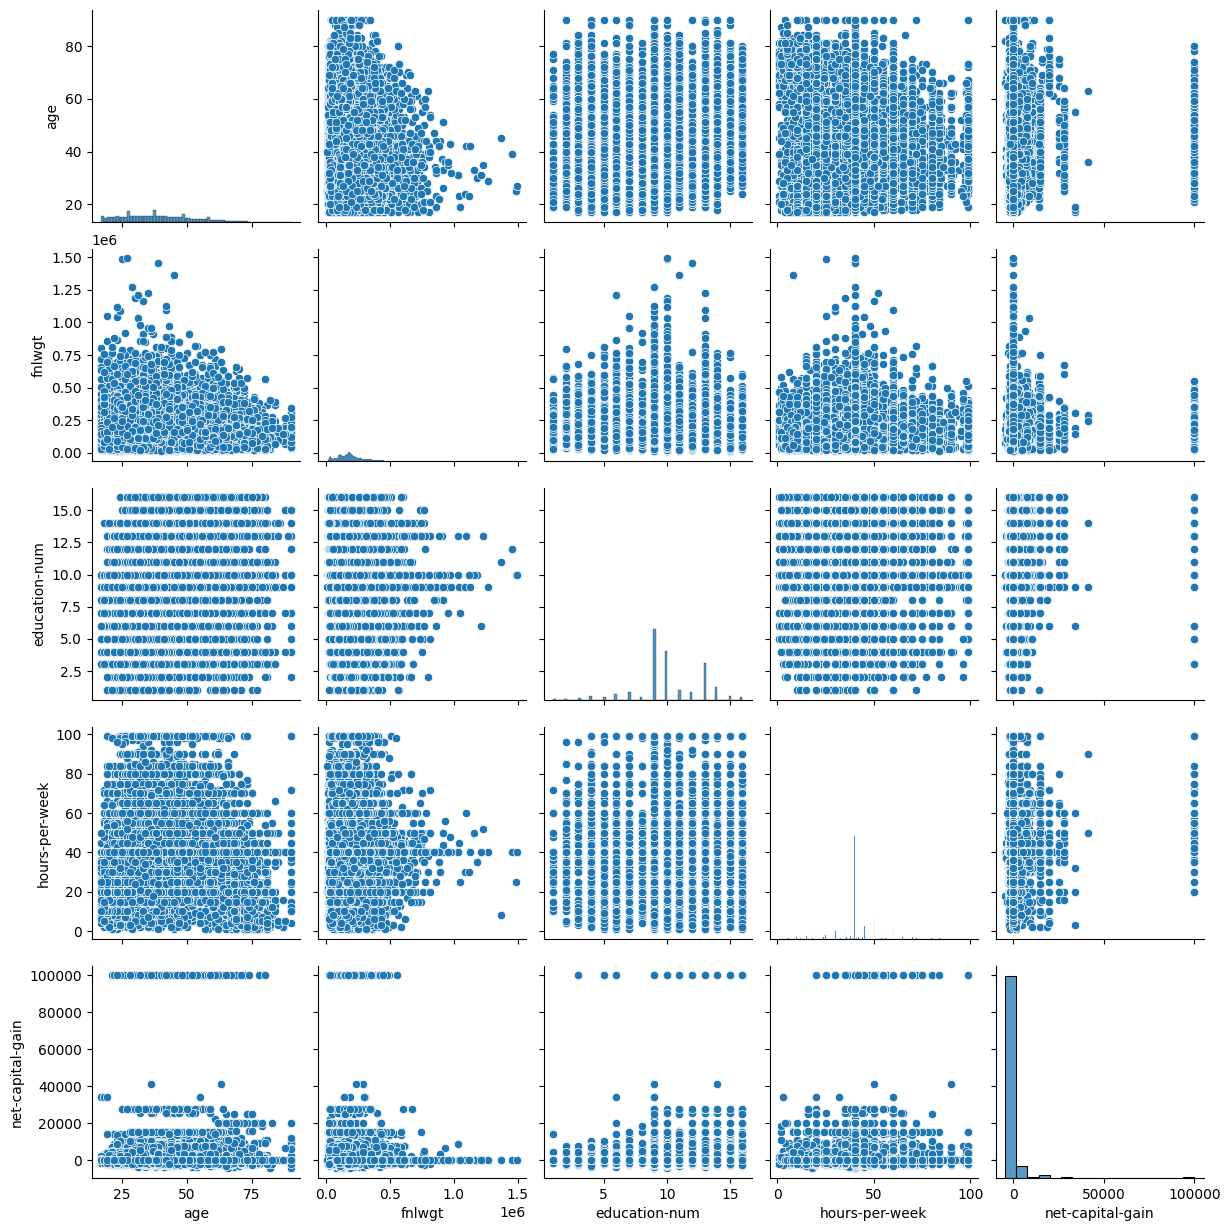

In [ ]:
# Visualize the data

# Important note:
# Run imputation and then transformation before data visualization! This is so
# we don't map null values, we don't categorize null values, and don't
# map unnecessary columns

sns.pairplot(X)

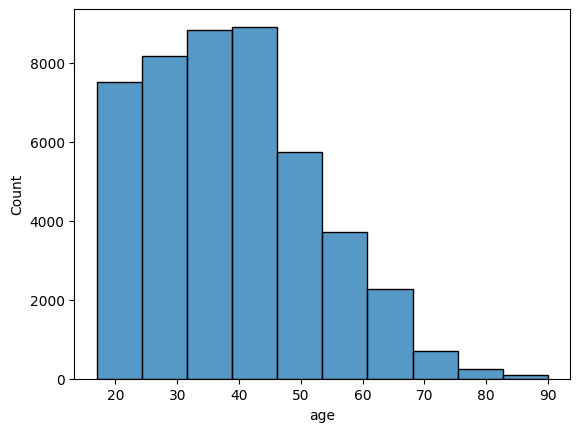

In [ ]:
# (Larry Mei) I will make the plots better later (like add titles or something)
sns.histplot(X['age'], bins=10);

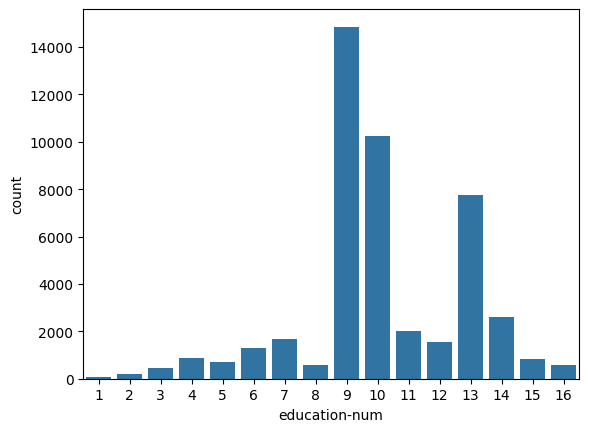

In [ ]:
sns.countplot(x='education-num', data=X);

In [ ]:
sns.histplot(X['hours-per-week'], bins=10);

In [ ]:
sns.countplot(x='sex', data=X);

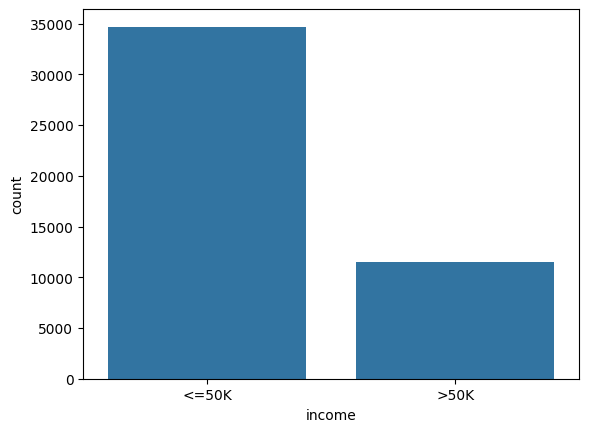

In [ ]:
sns.countplot(x='income', data=y);